## Import everything we need

In [1]:
from qiskit.circuit.library import TwoLocal, RealAmplitudes, EfficientSU2
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
from qiskit.providers.options import Options
from qiskit_algorithms.optimizers import SLSQP, COBYLA, ADAM, SPSA, QNSPSA, CG, GradientDescent, POWELL, NFT
from qiskit.quantum_info import SparsePauliOp

import numpy as np
from tqdm import tqdm
import pandas as pd
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import networkx as nx
from pyhobo import Binary, Hamiltonian

## Setting up matplotlib

In [2]:
import matplotlib as mpl
import os

# Configure matplotlib to use LaTeX
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'comfortaa'
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.style.use('seaborn-v0_8')
# plt.style.use('default')


## Construct weight matrix 

In [18]:
# Read the Excel file
df = pd.read_excel("data\weight_matrix.xlsx", index_col=0)

# Read the Excel file
weight_matrix_df = pd.read_excel("data\weight_matrix.xlsx", index_col=0)

# Extract numerical values as a NumPy array
weight_matrix_array = weight_matrix_df.values

W = -np.array(weight_matrix_array,dtype = float)

num_pos = 12 


penality = 1.5*np.max(abs(W))

for i in range(len(W)):
    for j in range(len(W)):
        if W[i,j] == 0:
            W[i,j] = penality # + np.random.uniform()

node = W.shape[0] + 1
node_qubit = int(np.ceil(np.log2(node)))
num_qubits = node_qubit*num_pos
print('Number of qubits for nodes :', node_qubit)
print('Number of positions : ',num_pos)
print('Number of qubits required:', num_qubits)

print(pd.DataFrame(W))

Number of qubits for nodes : 3
Number of positions :  12
Number of qubits required: 36
      0     1     2     3     4     5     6
0  58.5 -34.0  58.5  58.5  58.5  58.5  58.5
1  58.5  58.5  58.5 -19.0  58.5  58.5  58.5
2  58.5  58.5  58.5  58.5 -38.0  58.5  58.5
3  58.5  58.5  58.5  58.5  58.5 -28.0  58.5
4 -39.0 -11.0  58.5  58.5  58.5  58.5  58.5
5  58.5  58.5  58.5  58.5  58.5  58.5 -30.0
6  58.5  58.5 -32.0  58.5  58.5  58.5  58.5


## Construct the Hamiltonian using PyHOBO

In [19]:
binary = Binary(num_nodes=node, num_positions=num_pos)

γ = 2*penality  # penality for first node to be occupied
δ = 2*penality  # penality for the continuity

cost_function_terms = []

for ti in tqdm(range(num_pos-1)):
    for i in range(1,node):
        for j in range(1,node):
            cost_function_terms.append([W[i-1,j-1], [[i, ti], [j, ti+1]]])

cost_function_terms.append([γ,[[0,0]]])

for ti in range(num_pos-1):
    cost_function_terms.append([δ,[[0,ti]]])
    cost_function_terms.append([-δ,[[0,ti],[0,ti+1]]])

H_op = Hamiltonian(binary, cost_function_terms)

op = H_op.ham_op_str()
print(pd.DataFrame(op))

100%|██████████| 11/11 [00:00<?, ?it/s]


                                        0         1
0    IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII  1.937500
1    IIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII  0.718750
2    IIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII  3.453125
3    IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII  0.750000
4    IIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII -1.296875
..                                    ...       ...
618  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZIZZ  1.648438
619  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZII -0.335938
620  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZIZ -5.898438
621  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZI -3.945312
622  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZZZZZ  1.679688

[623 rows x 2 columns]


## Constructing reference state

In [20]:
# Extract column names and convert to list
read = df.columns.tolist()

read.insert(0,'')
print(read)


## Finding source
source_node_found = False

# Is there a node without any in degree?
for i in range(len(weight_matrix_array)):
    if np.sum(weight_matrix_array[:,i]) == 0:
        print(i)
        source_node = i
        source_node_found = True
        break


# If not, choose the one with minimum weight in degree!
if not source_node_found:
    # Initialize an empty dictionary
    data_dict = {}

    # Open and read the file
    with open('data/edge_frequencies.txt', 'r') as file:
        for line in file:
            # Split the line into components
            parts = line.strip().split()
            key = (parts[0], parts[1])
            value = int(parts[2])
            data_dict[key] = value

    # Display the dictionary
    print(data_dict)

    # Find the key with the minimum value
    min_key = min(data_dict, key=lambda k: data_dict[k])
    min_value = data_dict[min_key]

    # Display the key and its value
    print(f"The key with the minimum value is: {min_key}")
    print(f"The minimum value is: {min_value}")

    for i in range(len(read)):
        if min_key[0] == read[i]:
            source_node = i
        if min_key[1] == read[i]:
            next_to_source = i

    print('Source node :', source_node,' Node next to source : ', next_to_source)

['', 'AAA', 'AAG', 'AGA', 'AGT', 'GAA', 'GTA', 'TAG']
{('GAA', 'AAG'): 11, ('GAA', 'AAA'): 39, ('AAG', 'AGT'): 19, ('AGT', 'GTA'): 28, ('AAA', 'AAG'): 34, ('GTA', 'TAG'): 30, ('TAG', 'AGA'): 32, ('AGA', 'GAA'): 38}
The key with the minimum value is: ('GAA', 'AAG')
The minimum value is: 11
Source node : 5  Node next to source :  2


In [7]:
ref = QuantumCircuit(num_qubits)

source_bit = Binary._num2bin(source_node,node_qubit)
next_to_source_bit = Binary._num2bin(next_to_source,node_qubit)

for i in range(len(source_bit)):
    if source_bit[i] == 1:
        ref.x(num_qubits-1-i)
    if next_to_source_bit[i] == 1:
        ref.x(num_qubits-1-node_qubit-i)

# ref.draw()

q_0: ─────
           
 q_1: ─────
           
 q_2: ─────
           
 q_3: ─────
           
 q_4: ─────
           
 q_5: ─────
           
 q_6: ─────
           
 q_7: ─────
           
 q_8: ─────
           
 q_9: ─────
           
q_10: ─────
           
q_11: ─────
           
q_12: ─────
           
q_13: ─────
           
q_14: ─────
           
q_15: ─────
           
q_16: ─────
           
q_17: ─────
           
q_18: ─────
           
q_19: ─────
           
q_20: ─────
           
q_21: ─────
           
q_22: ─────
           
q_23: ─────
           
q_24: ─────
           
q_25: ─────
           
q_26: ─────
           
q_27: ─────
           
q_28: ─────
           
q_29: ─────
           
q_30: ─────
      ┌───┐
q_31: ┤ X ├
      └───┘
q_32: ─────
      ┌───┐
q_33: ┤ X ├
      └───┘
q_34: ─────
      ┌───┐
q_35: ┤ X ├
      └───┘

## Variational form & anstaz 

In [21]:
ansatz = QuantumCircuit(num_qubits)

for i in range(num_pos-2):
    ansatz.append(EfficientSU2(node_qubit,su2_gates=["rx", "ry"], reps=1, parameter_prefix='φ' + str(i) , insert_barriers=True).decompose(), range(i*node_qubit,(i+1)*node_qubit))

ansatz = ref.compose(ansatz)

ansatz.decompose().draw()

## Optimization loop

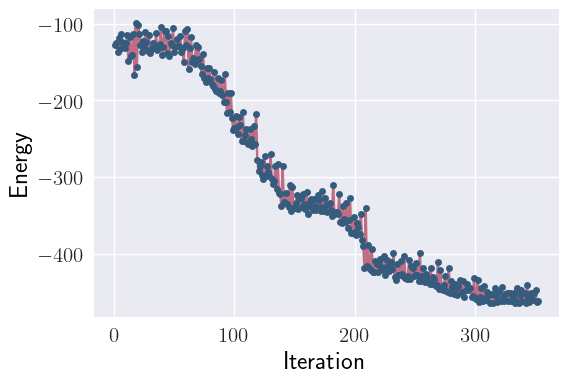

101010010100011101001010110111011101


In [22]:
Hop = SparsePauliOp.from_list(op)

## Optimizer : SPSA
# backend = Aer.get_backend('qasm_simulator')
# backend = AerSimulator(method = 'matrix_product_state')
backend = AerSimulator(method = 'matrix_product_state')

# backend = QasmSimulator(method='matrix_product_state')
options = Options()
options.shots = int(2**12) # 4000
sampler = BackendSampler(backend=backend)

# set classical optimizer
optimizer = COBYLA(maxiter=1000) # SPSA()

counts = []
values = []
params = []

# Function to plot energy after each iteration
def plot_energy(counts, values):
    fig, ax = plt.subplots(figsize = (6,4))
    ax.plot(counts, values, marker='o', linestyle='-',color = '#C06C84',markerfacecolor='#355C7D',markersize = 5)
    plt.tick_params(top=True, left=True, right=True, bottom=True,direction="in",axis='both', which='both', labelsize=15)
    font2 = {'family':'comfortaa','color':'black','size':18}
    ax.set_xlabel('Iteration',fontdict = font2)
    ax.set_ylabel('Energy',fontdict = font2)
    # plt.title('Energy vs Iteration')
    ax.grid(zorder=0)
    plt.show()


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(np.real(mean))
    # print(eval_count, "energy_exp = ", np.real(mean))
    params.append(parameters)
    # Plot energy after each iteration
    clear_output(wait=True)
    plot_energy(counts, values)

# initialize VQE using CVaR with alpha = 0.1

vqe = SamplingVQE(
    sampler,
    ansatz=ansatz,
    optimizer=optimizer,
#     aggregation=0.1,
#     initial_point = params,
    callback=store_intermediate_result,
    )

# Estimator approach

# vqe = VQE(
#     sampler,
#     ansatz=ansatz,
#     optimizer=optimizer,
# #     aggregation=0.1,
# #     initial_point = params,
#     callback=store_intermediate_result,
#     )

raw_result = vqe.compute_minimum_eigenvalue(Hop) 
print(raw_result.best_measurement['bitstring'])

val = raw_result.best_measurement['bitstring']
# np.savetxt('energy_spsa.txt',np.array(values))

# Define the filename
# filename = 'bit_spsa.txt'

# Open the file in write mode and save the string
# with open(filename, 'w') as file:
#     file.write(val)


## Checking the misalighments in the found solution

In [23]:
def violations(val):
    vio = 0 # number of misalighments
    num_seq = [] # sequence associated with quantum bit (val)

    for i in range(num_pos):
        num_seq.append(int(val[i*node_qubit:node_qubit*i+node_qubit],2))

    for i in range(num_pos-1):
        if W[num_seq[i]-1,num_seq[i+1]-1] >= 0 and num_seq[i] > 0 and num_seq[i+1] > 0:
            vio +=1

    return vio,num_seq

vio,num_seq = violations(val)

print('No of violations ',vio)


No of violations  3


## Visualizing using graph

In [24]:
path = []

for i in range(num_pos-1):
    path.append((read[num_seq[i]],read[num_seq[i+1]]))

path

[('GAA', 'AAG'),
 ('AAG', 'AAG'),
 ('AAG', 'AGT'),
 ('AGT', 'AGA'),
 ('AGA', 'GAA'),
 ('GAA', 'AAA'),
 ('AAA', 'AAG'),
 ('AAG', 'GTA'),
 ('GTA', 'TAG'),
 ('TAG', 'AGA'),
 ('AGA', 'GAA')]

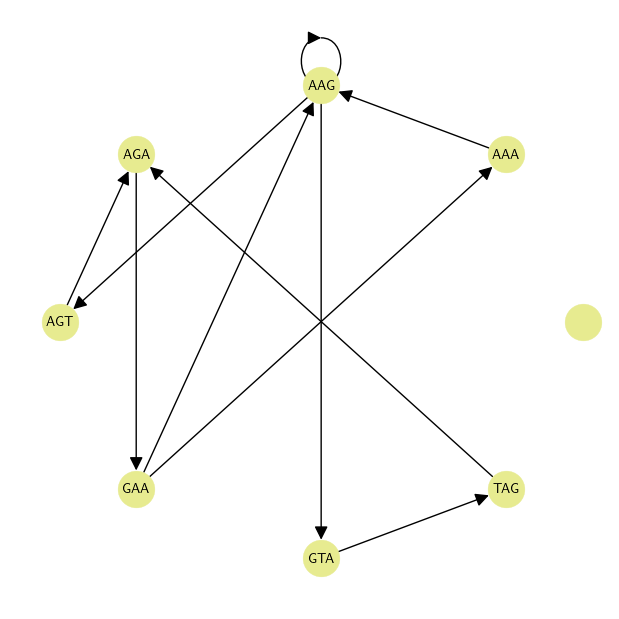

In [25]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
G.add_nodes_from(read)
G.add_edges_from(path)

# Draw the graph
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color="#E7EB90", font_size=10, font_weight="bold", arrowstyle="-|>", arrowsize=20)

# Draw edge labels

# nx.draw_networkx_edge_labels(G, pos, font_color="red", font_size=8)

# plt.title("Graph Visualization")
plt.show()

## Are there other bits with zero violations?

In [26]:
dat = raw_result.eigenstate
dat1 = list(dat.keys())
nq = num_qubits # op.num_qubits
b = []
for i in range(len(dat1)):
    b.append(format(dat1[i],'0>'+str(nq)+'b'))

possible_soln = []

for i in range(len(b)):
    objvio, numseq = violations(b[i])
    if objvio == 0:
        # print(objvio)
        possible_soln.append(b[i])
        
for ii in range(len(possible_soln)):

    currvio, curr_seq = violations(possible_soln[ii])

    path = []

    for i in range(num_pos-1):
        path.append((read[curr_seq[i]],read[curr_seq[i+1]]))
    
    print(path)